# Validating ASTER Thermal Infrared Imaging for use in Snow Models

## Summary
This project investigates how satellite thermal infrared imaging represents snow surface temperature for an improved understanding of snowmelt timing and magnitude over larger spatial areas and timescales.

## Background
### Snowmelt and the Hydrologic Cycle
* Snowmelt contributes up to 75% of water supply in parts of the western United States (Dettinger, M. 2005)
* Few ground observations of snow surface temperature are available and represent a small area

### Thermal Imaging and Satellites
* Satellite thermal imaging can remotely determine surface temperature over large areas/time scales
* Satellite imaging is limited by its coarse spatial resolution

## Research Questions
1. Does the 90 meter resolution ASTER thermal infrared imagery accurately capture the mean snow surface temperature over the upper Tuolumne area in Yosemite, California?
2. If ASTER does not accurately represent the mean snow surface temperature, is there an explanation for errors (topography, vegetation, etc.) and a function to correct ASTER?

## Datasets
* ASTER (Advanced Spaceborne Thermal Emission and Reflection Radiometer) 90-meter TIR
* UW Applied Physics Laboratory airborne TIR camera
* Future: UW Mountain Hydrology Research Group ground observations

## Import Statements, Reading in Images, and 

In [1]:
import aster_processing_fn
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import xarray as xr
import rioxarray
import numpy as np
import scipy.stats as stats

/srv/conda/envs/notebook/lib/python3.8/site-packages/rasterio/plot.py:263: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(arr.shape) is 2:


In [2]:
#%matplotlib widget
%matplotlib inline

In [3]:
# Identify TIFF files
airborne_tif = './airborne/YOSEMITE_IR_PLANE_2017Apr21_mosaicked_9_calCam.tif'
aster_tif = './aster/AST_L1T_00304212017185107_20170422082541_26960_ImageData14.tif'

In [4]:
# Read in ASTER and convert to brightness temperature using xarray and aster_processing_fn
aster_src = xr.open_rasterio(aster_tif)
aster_band = 14
aster_rad = aster_processing_fn.tir_dn2rad(aster_src, aster_band)
aster_tb =  aster_processing_fn.tir_rad2tb(aster_rad, aster_band)
# Convert to degC
aster_tb_degC = aster_tb-273.15
aster_tb_degC.rio.set_crs(aster_src.crs)

# Read in Airborne
air_src = xr.open_rasterio(airborne_tif)

# Reproject ASTER to airborne
aster_src_repr = aster_tb_degC.rio.reproject_match(air_src)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


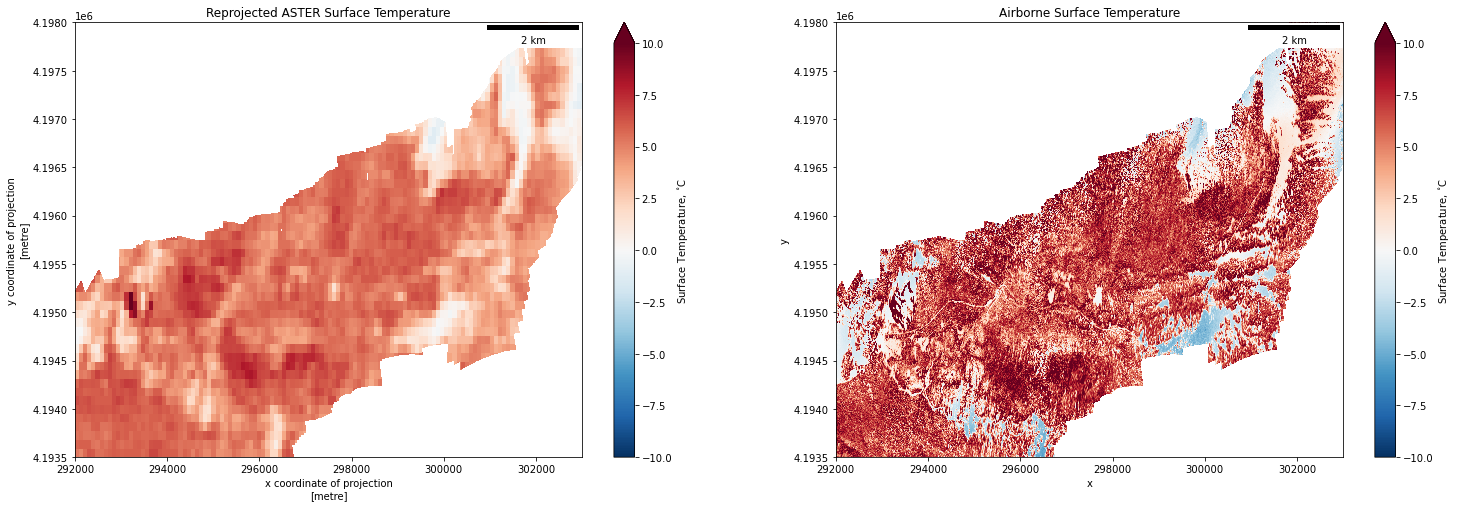

In [5]:
# Mask reprojected ASTER to study area
aster_masked = aster_src_repr.where(~np.isnan(air_src))

# Plot both datasets
f, ax = plt.subplots(1,2,figsize=(25,8))

aster_masked.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},vmin=-10,vmax=10, ax=ax[0])
ax[0].add_artist(ScaleBar(1.0))
ax[0].set_title('Reprojected ASTER Surface Temperature')

air_src.plot(cmap='RdBu_r', cbar_kwargs={'label': 'Surface Temperature, $^{\circ}$C'},vmin=-10,vmax=10,ax=ax[1])
ax[1].add_artist(ScaleBar(1.0))
ax[1].set_title('Airborne Surface Temperature');

## Calculate and Analyze Difference Map

In [6]:
# Calculate difference map
diff = aster_masked-air_src

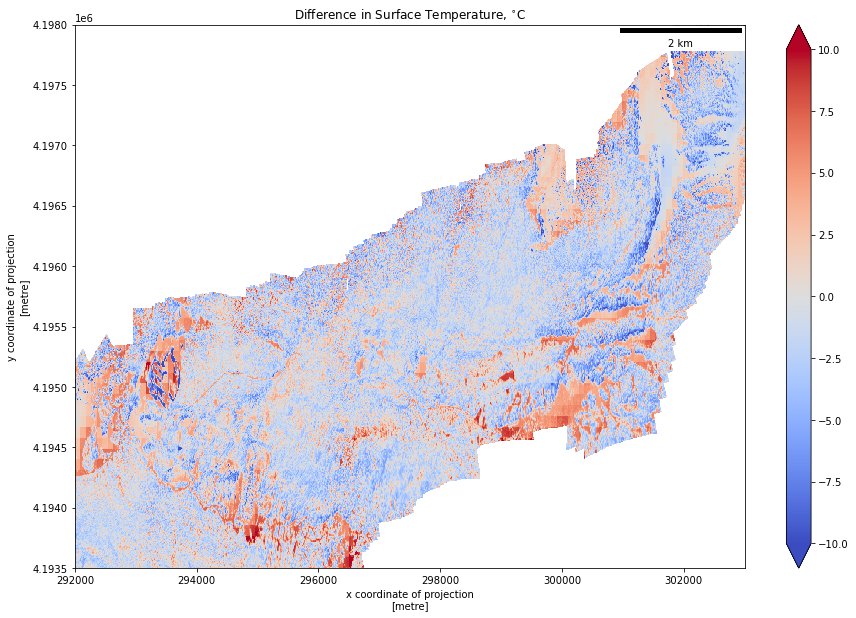

In [7]:
# Plot difference map = how much warmer ASTER is
f, ax = plt.subplots(figsize=(15,10))
diff.plot(cmap='coolwarm',vmin=-10,vmax=10)
ax.add_artist(ScaleBar(1.0))
ax.set_title('Difference in Surface Temperature, $^{\circ}$C');

In [8]:
# Calculate statistics of difference map
mean_diff = diff.mean().item(0)
median_diff = diff.median().item(0)
std_diff = diff.std().item(0)
max_diff = abs(diff).max().item(0)

print('Mean Difference = ', np.round(mean_diff,3))
print('Median Difference = ', np.round(median_diff,3))
print('Standard Devation of Differences = ', np.round(std_diff,3))
print('Maximum Difference = ', np.round(max_diff,3))

Mean Difference =  -0.52
Median Difference =  -0.818
Standard Devation of Differences =  3.203
Maximum Difference =  23.293


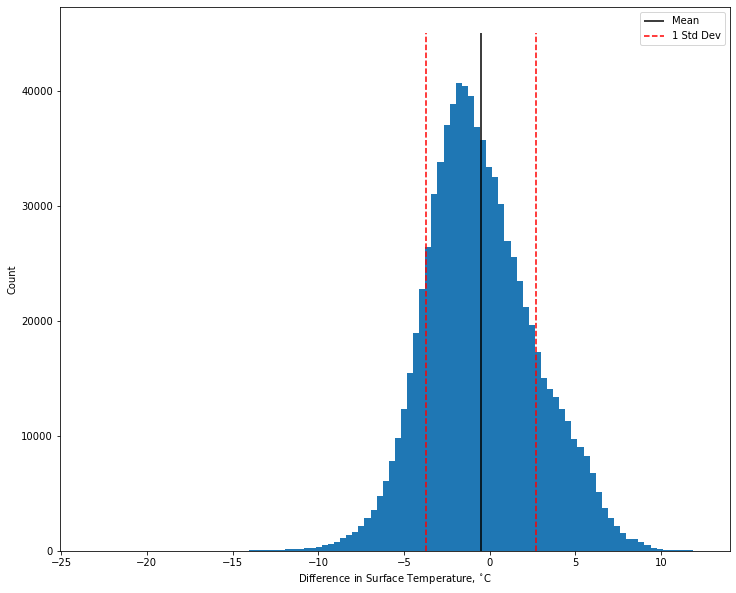

In [9]:
# Plot histogram of differences
f, ax = plt.subplots(figsize=(12,10))

plt.hist(diff.values.ravel(),bins=100)

# Plot vline at mean
ax.vlines(mean_diff, ymin=0, ymax=45000, color='k', label='Mean')

# Plot vline at +- 1stdev
x_stdev = [mean_diff+std_diff, mean_diff-std_diff]
ax.vlines(x_stdev, ymin=0, ymax=45000, color='r', linestyles='dashed', label='1 Std Dev')

plt.legend()

ax.set_xlabel('Difference in Surface Temperature, $^{\circ}$C')
ax.set_ylabel('Count');

In [10]:
# Calculate percent error
percent_error = np.divide(abs(diff),abs(air_src))
percent_error = percent_error*100

In [11]:
# Calculate statistics of difference map
mean_error = percent_error.mean().item(0)
median_error = percent_error.median().item(0)
std_error = percent_error.std().item(0)
max_error = abs(percent_error).max().item(0)

print('Mean % Error = ', np.round(mean_error,3))
print('Median % Error = ', np.round(median_error,3))
print('Standard Devation of % Error = ', np.round(std_error,3))
print('Maximum % Error = ', np.round(max_error,3))

Mean % Error =  435.218
Median % Error =  37.066
Standard Devation of % Error =  50285.489
Maximum % Error =  38859062.094


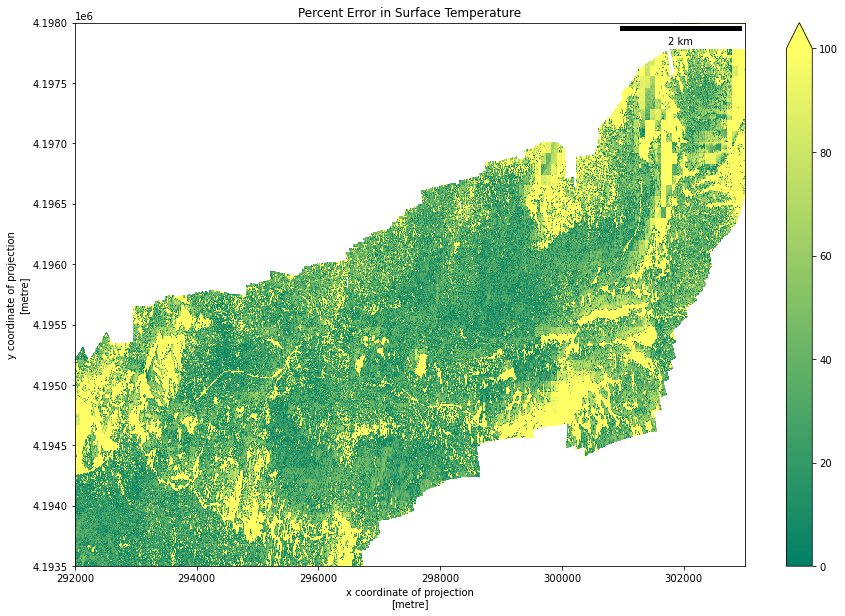

In [12]:
# Plot percent error
f, ax = plt.subplots(figsize=(15,10))
percent_error.plot(cmap='summer',vmin=0,vmax=100)
ax.add_artist(ScaleBar(1.0))
ax.set_title('Percent Error in Surface Temperature');

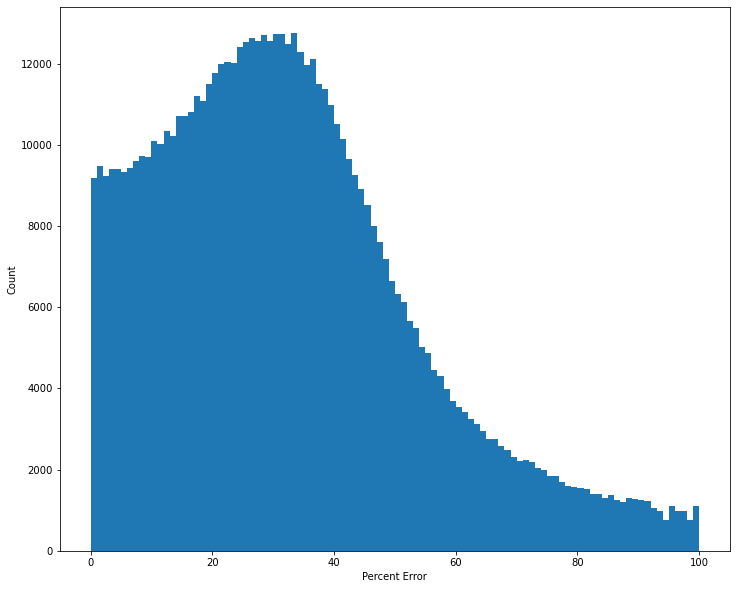

In [13]:
# Plot histogram of percent error
f, ax = plt.subplots(figsize=(12,10))

plt.hist(percent_error.values.ravel(),bins=100,range=(0,100))
ax.set_xlabel('Percent Error')
ax.set_ylabel('Count');

## NDVI (Normalized Difference Vegetation Index)

In [14]:
# Identify red and near infrared images
red_path = './aster/AST_L1T_00304212017185107_20170422082541_26960_ImageData2.tif'
nir_path = './aster/AST_L1T_00304212017185107_20170422082541_26960_ImageData3N.tif'

In [15]:
# Pull red, nir, reproject to airborne resolution
red_src = xr.open_rasterio(red_path)
nir_src = xr.open_rasterio(nir_path)

red = red_src.rio.reproject_match(air_src)
nir = nir_src.rio.reproject_match(air_src)

/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [16]:
# Calculate NDVI and mask
NDVI = (nir-red)/(nir+red)
NDVI_masked = NDVI.where(~np.isnan(air_src))

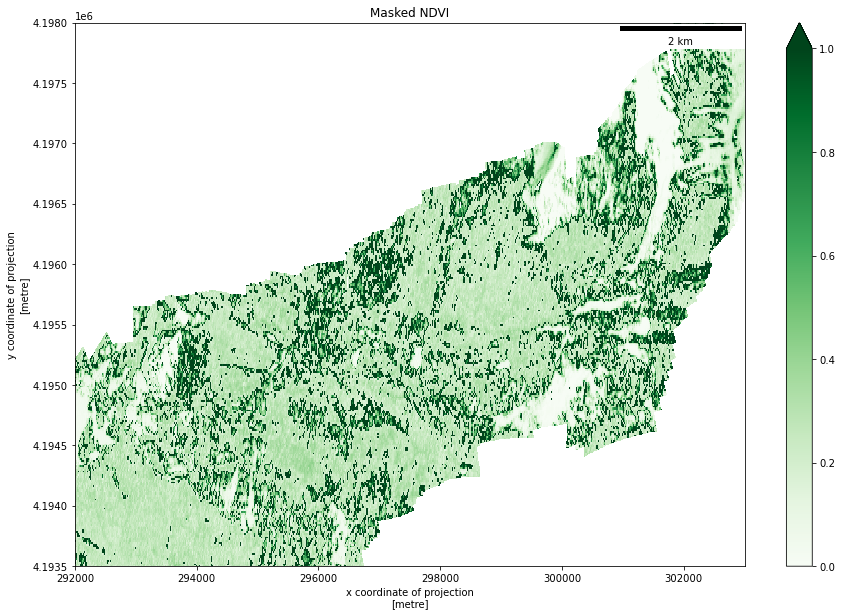

In [17]:
# Plot NDVI
f, ax = plt.subplots(figsize=(15,10))
NDVI_masked.plot(ax=ax, vmin=0, vmax=1,cmap='Greens')
ax.add_artist(ScaleBar(1.0))
ax.set_title('Masked NDVI');

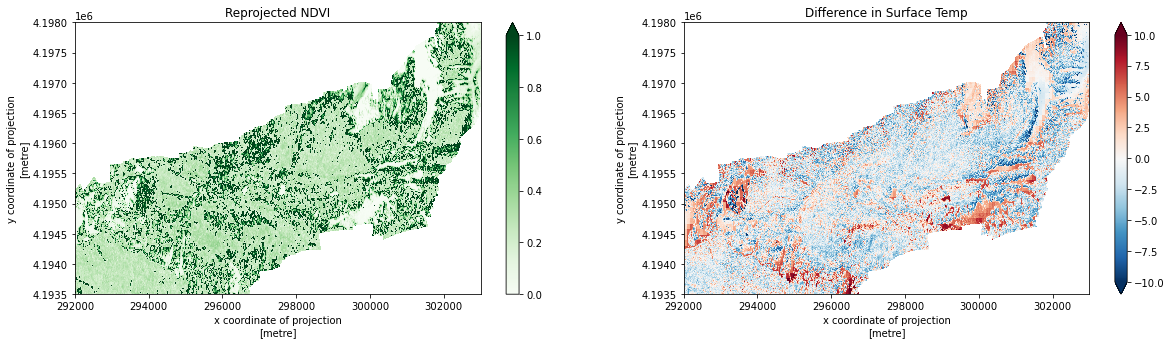

In [18]:
f, [ax1, ax2] = plt.subplots(1,2)

NDVI_masked.plot(ax=ax1, vmin=0, vmax=1, cmap='Greens')
ax1.set_title('Reprojected NDVI')
diff.plot(ax=ax2, vmin=-10, vmax=10, cmap='RdBu_r')
ax2.set_title('Difference in Surface Temp')

f.set_figwidth(20)
f.set_figheight(5);

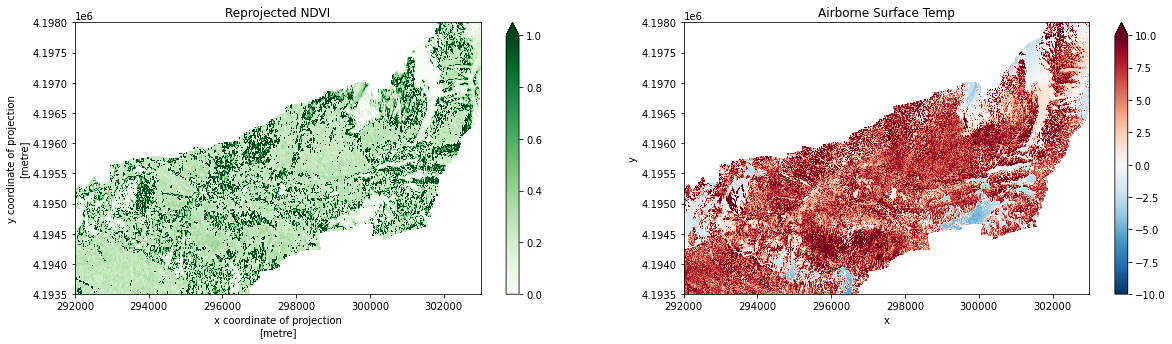

In [19]:
f, [ax1, ax2] = plt.subplots(1,2)

NDVI_masked.plot(ax=ax1, vmin=0, vmax=1, cmap='Greens')
ax1.set_title('Reprojected NDVI')
air_src.plot(ax=ax2, vmin=-10, vmax=10, cmap='RdBu_r')
ax2.set_title('Airborne Surface Temp')

f.set_figwidth(20)
f.set_figheight(5);

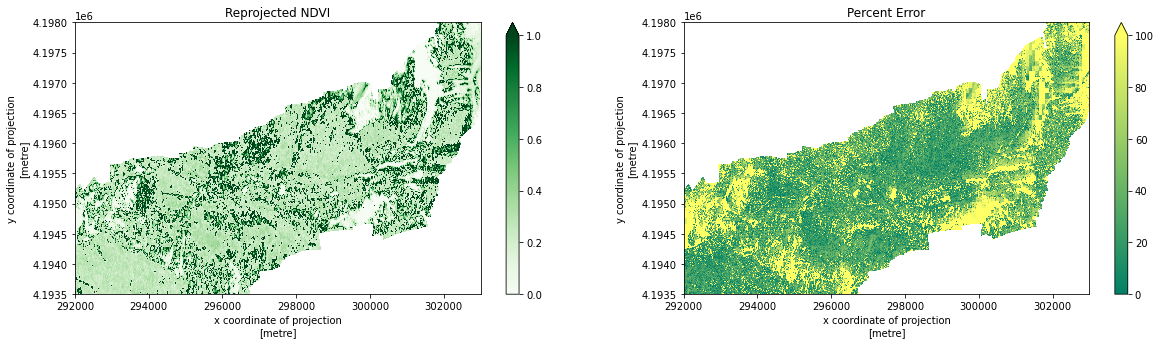

In [20]:
f, [ax1, ax2] = plt.subplots(1,2)

NDVI_masked.plot(ax=ax1, vmin=0, vmax=1, cmap='Greens')
ax1.set_title('Reprojected NDVI')
percent_error.plot(ax=ax2, vmin=0, vmax=100, cmap='summer')
ax2.set_title('Percent Error')

f.set_figwidth(20)
f.set_figheight(5);

In [21]:
air_where_NDVI = air_src.where(~np.isnan(NDVI_masked))

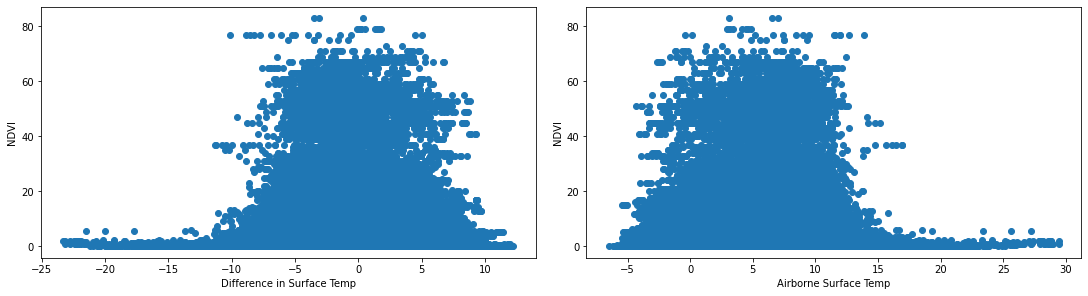

In [22]:
# Plot histogram of NDVI
f, [ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(15,4),constrained_layout=True)

ax1.scatter(diff,NDVI_masked)
ax1.set_ylabel('NDVI')
ax1.set_xlabel('Difference in Surface Temp')

ax2.scatter(air_where_NDVI,NDVI_masked)
ax2.set_ylabel('NDVI')
ax2.set_xlabel('Airborne Surface Temp');

## Future Steps
1. Validate airborne data with ground observations
2. Formal data analysis on NDVI
3. Scaling function and consideration of other variables - extreme temperature, topography
4. Look at different ASTER bands

## References
Dettinger, M. (2005). Changes in streamflow timing in the western United States in recent decades. USGS Numbered Series. doi:10.3133/fs20053018

Pestana, S., Chickadel, C. C., Harpold, A., Kostadinov, T. S., Pai, H., Tyler, S., et al. (2019). Bias correction of airborne thermal infrared observations over forests using melting snow. Water Resources Research, 55. https://doi.org/10.1029/2019WR025699